In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#plt.style.available
plt.style.use('seaborn-talk')
plt.style.use('seaborn-dark')

# K-bandits simulation with Numpy

Number of bandits, number of runs and number of time steps:

In [52]:
k = 10
runs = 1000  # number of independent k-bandits problems
steps = 10000  # number of time steps (repetitions of each experiment)

# Creation of the k-bandits rewards tensor

Generate $runs$ problems, by creating the a $rewards$ matrix with all the possible problems.

Each problem must have $k$ different values of $q_*(a)$ (that is $a \in [1,k]$).

$q_*(a)$ is the mean of the normal random reward generator for each bandit.

In [53]:
bandits = np.random.normal(size=(1,k))

In [54]:
# Each row is one of the independent problems, each column is the mean for that bandit in that problem
rewards = np.random.normal(bandits, size=(runs,k))

We are going to try different values of $\alpha$ and $\epsilon$.

In [55]:
alphas = [-1, 0.001, 0.01, 0.5]
epsilons = np.array([0, 0.1, 0.25])

We must also keep estimates for each bandit, in each problem. 

We will update the estimates for each problem and bandit as we learn from experience.

We will also have estimates for different strategies, that will be set by $\alpha$ and $\epsilon$.

In [56]:
estimates = np.zeros((len(epsilons), len(alphas), runs, k))

Then, for each step, we will have an average reward between all the problems.

We will keep an average value of rewards for each $\alpha$ and $\epsilon$:

In [57]:
avgs = np.zeros((len(epsilons), len(alphas), steps))

In [58]:
rewards.shape

(1000, 10)

In [59]:
estimates[:,:,0,:].argmax(axis=2)

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [60]:
def choose_bandit(estimates, experiment, epsilons):
    bandit = np.argmax(estimates[:,:,experiment], axis=2)
    for pe, e in enumerate(epsilons):
        if (np.random.rand() < e):
            bandit[pe,:] = np.random.randint(0, k)
        
    return bandit

In [61]:
for step in range(steps):  # time steps
    for run in range(runs):  # calculate all problems for each time stemp
        # choose greedily or explore, depending on epsilon
        choices = choose_bandit(estimates, run, epsilons)
        # We reshape choices for indexing in rewards,
        # then reshape the output to have the same shape as the epsilons and alphas tensor
        reward = rewards[run][choices.reshape(-1)].reshape((len(epsilons),-1))
        for pe, e in enumerate(epsilons):
            for pa, a in enumerate(alphas):
                choice = choices[pe,pa]
                if a < 0:
                    # alpha negative means that we are using an average value
                    a = 1/(step + 1)
                estimates[pe,pa,run,choice] = estimates[pe,pa,run,choice] + a*(reward[pe,pa] - estimates[pe,pa,run,choice])
        
    # We have now the estimates for this problem in this step
    # For each problem, we aggregate all rewards from each bandit, and then average for that run
    avgs[:,:,step] = estimates.sum(axis=3).mean(axis=2)
    if (step%1000 == 0):
        print("%d time steps" % step)

0 time steps
1000 time steps
2000 time steps
3000 time steps
4000 time steps
5000 time steps
6000 time steps
7000 time steps
8000 time steps
9000 time steps


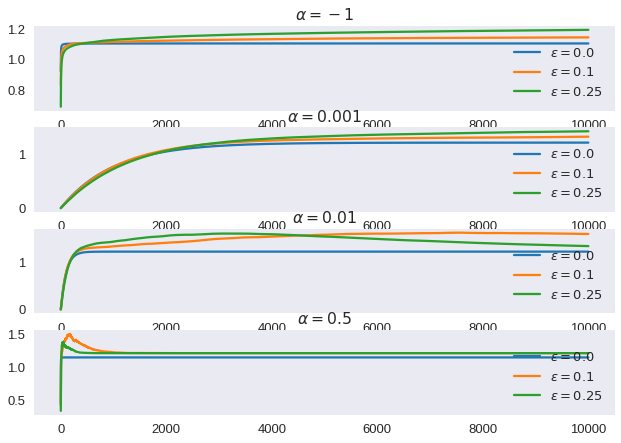

In [63]:
total_plots = len(alphas)
for index,alpha in enumerate(alphas):
    plt.subplot(total_plots, 1, index + 1)
    lines = plt.plot(np.transpose(avgs[:,index,:]))
    plt.legend(lines, [r"$\epsilon=" + str(e) + "$" for e in epsilons], loc='lower right')
    plt.title(r"$\alpha=" + str(alpha) + "$")